with some reference to 
* https://www.kaggle.com/code/lingyixia/resnet18-base
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Setting Up

In [27]:
import copy
from datetime import datetime
import io
from matplotlib import pyplot as plt
import numpy as np
import os.path
import pandas as pd
from pdb import set_trace as st
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , models
from torch.optim import SGD

np.random.seed(21052) # ふlo五二
torch.manual_seed(21052)
device = 'cuda'
DATA_PATH = '../data/tfrecords-jpeg-512x512/' # can ignore the rest; they're all the same except resolution.
MODEL_WEIGHTS_PATH = './models/'


In [ ]:
class FlowerDataset(Dataset):
    def __init__(self, images, classes, ids, transform, mode):
        self.images = images
        self.classes = classes
        self.ids = ids
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(io.BytesIO(self.images[idx]))
        img = self.transform(img)
        if self.mode == "test":
            idd = self.ids[idx]
            return (img, idd)
        else:
            label = self.classes[idx]
            return (img, label)
        
feats = {
    'train': {
        'class': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    },
    'val': {
        'class': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    },
    'test': {
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
}

data_elems = {
    'train': {'ids': [], 'images': [], 'classes': []},
    'val': {'ids': [], 'images': [], 'classes': []},
    'test': {'ids': [], 'images': []}
}

transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # https://pytorch.org/hub/pytorch_vision_resnet/
])

for dset_name in ['train', 'val', 'test']:
    dataset_path = os.path.join(DATA_PATH, dset_name)
    data_list = map(lambda path: tf.data.TFRecordDataset(os.path.join(dataset_path, path)), os.listdir(dataset_path))
    for tl in data_list:
        for t in tl.map(lambda x: tf.io.parse_single_example(x, feats[dset_name])):
            data_elems[dset_name]['ids'].append(str(t["id"].numpy())[2:-1])
            data_elems[dset_name]['images'].append(t["image"].numpy())
            if dset_name != 'test':
                data_elems[dset_name]['classes'].append(t["class"].numpy())

train_ds = FlowerDataset(data_elems['train']['images'], data_elems['train']['classes'], None, transform, 'train')
val_ds = FlowerDataset(data_elems['val']['images'], data_elems['val']['classes'], None, transform, 'val')
test_ds = FlowerDataset(data_elems['test']['images'], None, data_elems['test']['ids'], transform, 'test')

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

In [2]:
def train_model(model, epochs=10, lr=0.0005, eval_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    losses = []
    val_f1s = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs} at {datetime.now()}==========')
        
        model.train()
        total_iter_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_pred_probs = model(x)
            loss = criterion(y_pred_probs, y)
            total_iter_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Training loss was {total_iter_loss / len(train_ds)}')
        losses.append(total_iter_loss.cpu().detach().numpy().item())
        
        if epoch % eval_every == 0:
            model.eval()
            
            ys = []
            y_preds = []
            
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)
                y_pred = torch.max(model(x), 1)[1]
                ys.append(y)
                y_preds.append(y_pred)
            
            y = torch.cat(ys).cpu()
            y_pred = torch.cat(y_preds).cpu()
            
            f1 = f1_score(y, y_pred, average='macro')
            val_f1s.append(f1)
            acc = torch.sum(y == y_pred).item()
            val_accs.append(acc)
            print(f'Validated with f1={f1} and acc={acc}/{len(y)}')
            
    return losses, val_f1s, val_accs

## Sanity check (random guesses)

In [10]:
ys = []
y_preds = []

for x, y in val_dl:
    y_pred = torch.floor(torch.rand(y.shape) * 104)
    ys.append(y)
    y_preds.append(y_pred)

y = torch.cat(ys).cpu()
y_pred = torch.cat(y_preds).cpu()

f1 = f1_score(y, y_pred, average='macro')
print(f1)
acc = torch.sum(y == y_pred).item()
print(f'{acc}/{len(y)}')

0.005980498956210242
31/3712


## ResNet18 with initialization

In [2]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
resnet18 = resnet18.to(device)

losses = []
val_f1s = []
val_accs = []

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.05)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.02)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 09:54:15.898017==========
Training loss was 0.07108781486749649
Validated with f1=0.01715193609484355 and acc=769/3712
Epoch 1/25 at 2022-12-14 09:59:06.893883==========
Training loss was 0.06968242675065994
Validated with f1=0.018366165085456004 and acc=785/3712
Epoch 2/25 at 2022-12-14 10:02:42.126226==========
Training loss was 0.06929579377174377
Validated with f1=0.028497752615533743 and acc=1010/3712
Epoch 3/25 at 2022-12-14 10:06:12.656285==========
Training loss was 0.06852374225854874
Validated with f1=0.030221164755278015 and acc=1052/3712
Epoch 4/25 at 2022-12-14 10:09:38.622202==========
Training loss was 0.06804725527763367
Validated with f1=0.03904721333669788 and acc=1172/3712
Epoch 5/25 at 2022-12-14 10:13:10.095300==========
Training loss was 0.06759592145681381
Validated with f1=0.05569762469499757 and acc=1317/3712
Epoch 6/25 at 2022-12-14 10:16:42.464832==========
Training loss was 0.06709662824869156
Validated with f1=0.05953120629234698 an

Exception ignored in: <function UniquePtr.__del__ at 0x0000020C12EFB1C0>
Traceback (most recent call last):
  File "C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [8]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.01)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 15:58:45.127569==========
Training loss was 0.06051061674952507
Validated with f1=0.3752191957160929 and acc=2507/3712
Epoch 1/25 at 2022-12-14 16:01:04.258622==========
Training loss was 0.06048086658120155
Validated with f1=0.3759285567168699 and acc=2500/3712
Epoch 2/25 at 2022-12-14 16:04:30.306462==========
Training loss was 0.06045164540410042
Validated with f1=0.37581677727931273 and acc=2510/3712
Epoch 3/25 at 2022-12-14 16:07:33.003003==========
Training loss was 0.06044040620326996
Validated with f1=0.37548295061853476 and acc=2506/3712
Epoch 4/25 at 2022-12-14 16:10:26.734002==========
Training loss was 0.06044003739953041
Validated with f1=0.37438379498297675 and acc=2502/3712
Epoch 5/25 at 2022-12-14 16:13:57.465240==========
Training loss was 0.06042325496673584
Validated with f1=0.37521647683262493 and acc=2507/3712
Epoch 6/25 at 2022-12-14 16:17:02.536331==========
Training loss was 0.060423050075769424
Validated with f1=0.37490131245832736 and 

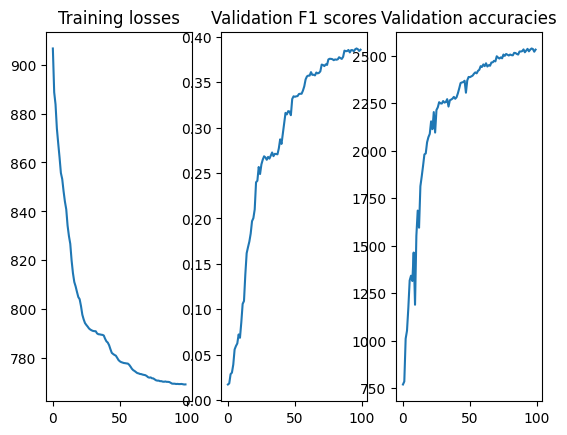

In [12]:

plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [19]:
torch.save(resnet18.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet18'))

## ResNet101 with transfer learning

In [2]:
def train_model2(model, params, epochs=10, lr=0.0005, eval_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params, lr=lr)
    
    losses = []
    val_f1s = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs} at {datetime.now()}==========')
        
        model.train()
        total_iter_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_pred_probs = model(x)
            loss = criterion(y_pred_probs, y)
            total_iter_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Training loss was {total_iter_loss / len(train_ds)}')
        losses.append(total_iter_loss.cpu().detach().numpy().item())
        
        if epoch % eval_every == 0:
            model.eval()
            
            ys = []
            y_preds = []
            
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)
                y_pred = torch.max(model(x), 1)[1]
                ys.append(y)
                y_preds.append(y_pred)
            
            y = torch.cat(ys).cpu()
            y_pred = torch.cat(y_preds).cpu()
            
            f1 = f1_score(y, y_pred, average='macro')
            val_f1s.append(f1)
            acc = torch.sum(y == y_pred).item()
            val_accs.append(acc)
            print(f'Validated with f1={f1} and acc={acc}/{len(y)}')
            
    return losses, val_f1s, val_accs

In [10]:
resnet101 = models.resnet101(pretrained=True)
for param in resnet101.parameters():
    param.requires_grad = False

resnet101.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=104, bias=True),
    nn.Softmax(dim=1)
)

resnet101 = resnet101.to(device)

losses = []
val_f1s = []
val_accs = []

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model2(resnet101, resnet101.fc.parameters(), epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 20:41:07.214005==========
Training loss was 0.07192531228065491
Validated with f1=0.003396409300251861 and acc=358/3712
Epoch 1/25 at 2022-12-14 20:44:15.601048==========
Training loss was 0.07138335704803467
Validated with f1=0.0071231658092346115 and acc=520/3712
Epoch 2/25 at 2022-12-14 20:47:14.862051==========
Training loss was 0.0709356889128685
Validated with f1=0.007384253569507683 and acc=540/3712
Epoch 3/25 at 2022-12-14 20:50:10.596049==========
Training loss was 0.07087762653827667
Validated with f1=0.00720249402373524 and acc=539/3712
Epoch 4/25 at 2022-12-14 20:53:10.527009==========
Training loss was 0.0707007423043251
Validated with f1=0.012274047956404079 and acc=662/3712
Epoch 5/25 at 2022-12-14 20:56:05.712050==========
Training loss was 0.0703384280204773
Validated with f1=0.012019645835728019 and acc=678/3712
Epoch 6/25 at 2022-12-14 20:59:01.720048==========
Training loss was 0.07027822732925415
Validated with f1=0.012091734108055235 and a

In [13]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model2(resnet101, resnet101.fc.parameters(), epochs=25, lr=0.001)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 23:45:17.926836==========
Training loss was 0.07011760026216507
Validated with f1=0.012083641301468403 and acc=690/3712
Epoch 1/25 at 2022-12-14 23:48:24.423946==========
Training loss was 0.07012419402599335
Validated with f1=0.01198507616051599 and acc=691/3712
Epoch 2/25 at 2022-12-14 23:51:31.657002==========
Training loss was 0.0701301246881485
Validated with f1=0.012058632743262632 and acc=690/3712
Epoch 3/25 at 2022-12-14 23:54:39.166526==========
Training loss was 0.0701289176940918
Validated with f1=0.012073420142409731 and acc=688/3712
Epoch 4/25 at 2022-12-14 23:58:01.731528==========
Training loss was 0.07013582438230515
Validated with f1=0.01210288951732851 and acc=688/3712
Epoch 5/25 at 2022-12-15 00:01:17.478309==========
Training loss was 0.07012587040662766
Validated with f1=0.012160701794794969 and acc=689/3712
Epoch 6/25 at 2022-12-15 00:04:29.061848==========
Training loss was 0.07011736184358597
Validated with f1=0.012093008887061812 and ac

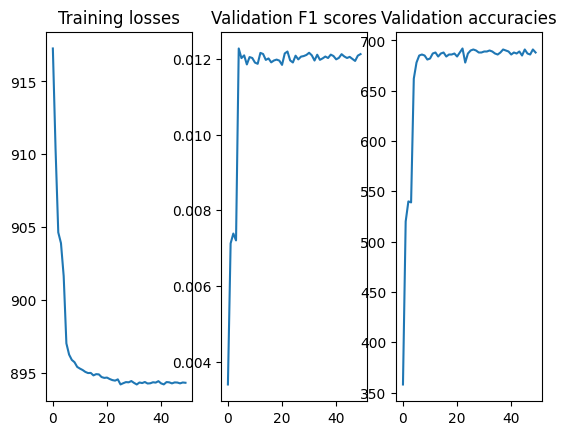

In [14]:
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [ ]:
torch.save(resnet101.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet101'))

## ResNet34 with initialization

In [3]:
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
resnet34 = resnet34.to(device)

losses = []
val_f1s = []
val_accs = []

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-15 23:41:50.275734==========
Training loss was 0.07107633352279663
Validated with f1=0.013610830725752142 and acc=700/3712
Epoch 1/25 at 2022-12-15 23:45:34.313691==========
Training loss was 0.06933742761611938
Validated with f1=0.025037324521310137 and acc=982/3712
Epoch 2/25 at 2022-12-15 23:48:47.347825==========
Training loss was 0.06851490586996078
Validated with f1=0.031301650154246755 and acc=1096/3712
Epoch 3/25 at 2022-12-15 23:51:56.265302==========
Training loss was 0.06816298514604568
Validated with f1=0.03171114305570086 and acc=1120/3712
Epoch 4/25 at 2022-12-15 23:55:04.872346==========
Training loss was 0.0680440366268158
Validated with f1=0.0436261280835813 and acc=1182/3712
Epoch 5/25 at 2022-12-15 23:58:29.324746==========
Training loss was 0.06736338883638382
Validated with f1=0.07185051007855338 and acc=1397/3712
Epoch 6/25 at 2022-12-16 00:01:34.098639==========
Training loss was 0.06651289761066437
Validated with f1=0.08794403626829227 and 

In [5]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=25, lr=0.05)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-16 01:03:18.198030==========
Training loss was 0.06152801215648651
Validated with f1=0.3160459152280313 and acc=2397/3712
Epoch 1/25 at 2022-12-16 01:06:32.100801==========
Training loss was 0.06140241026878357
Validated with f1=0.31688345036493526 and acc=2408/3712
Epoch 2/25 at 2022-12-16 01:09:44.577991==========
Training loss was 0.061361223459243774
Validated with f1=0.31499523978111904 and acc=2384/3712
Epoch 3/25 at 2022-12-16 01:12:53.878150==========
Training loss was 0.06132771447300911
Validated with f1=0.31761090098568145 and acc=2409/3712
Epoch 4/25 at 2022-12-16 01:16:03.689286==========
Training loss was 0.06127144768834114
Validated with f1=0.3266561701172654 and acc=2430/3712
Epoch 5/25 at 2022-12-16 01:19:17.995291==========
Training loss was 0.0612003318965435
Validated with f1=0.32734415405581846 and acc=2436/3712
Epoch 6/25 at 2022-12-16 01:22:30.526098==========
Training loss was 0.06118516996502876
Validated with f1=0.32308375890846963 and a

In [6]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=25, lr=0.02)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-16 02:22:46.990678==========
Training loss was 0.06039073318243027
Validated with f1=0.3832442407063227 and acc=2532/3712
Epoch 1/25 at 2022-12-16 02:25:48.982918==========
Training loss was 0.06031084805727005
Validated with f1=0.3859040743509301 and acc=2561/3712
Epoch 2/25 at 2022-12-16 02:28:41.084872==========
Training loss was 0.060283269733190536
Validated with f1=0.38813178070938387 and acc=2556/3712
Epoch 3/25 at 2022-12-16 02:31:31.390920==========
Training loss was 0.06025124713778496
Validated with f1=0.38700079393076897 and acc=2547/3712
Epoch 4/25 at 2022-12-16 02:34:22.003880==========
Training loss was 0.060235653072595596
Validated with f1=0.38717592617690844 and acc=2551/3712
Epoch 5/25 at 2022-12-16 02:37:11.059921==========
Training loss was 0.06022569537162781
Validated with f1=0.38667346995102087 and acc=2545/3712
Epoch 6/25 at 2022-12-16 02:40:01.325920==========
Training loss was 0.06021701171994209
Validated with f1=0.38874637288519565 and

In [11]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=25, lr=0.01)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-16 11:34:15.555720==========
Training loss was 0.059827983379364014
Validated with f1=0.41145384713517597 and acc=2591/3712
Epoch 1/25 at 2022-12-16 11:37:06.191000==========
Training loss was 0.05982416495680809
Validated with f1=0.4150780429102514 and acc=2607/3712
Epoch 2/25 at 2022-12-16 11:39:58.401562==========
Training loss was 0.05980255827307701
Validated with f1=0.4152868951069395 and acc=2608/3712
Epoch 3/25 at 2022-12-16 11:42:50.834555==========
Training loss was 0.05979490652680397
Validated with f1=0.41411560552046167 and acc=2600/3712
Epoch 4/25 at 2022-12-16 11:45:47.840499==========
Training loss was 0.059786465018987656
Validated with f1=0.41458397204745706 and acc=2605/3712
Epoch 5/25 at 2022-12-16 11:48:47.869685==========
Training loss was 0.05978158861398697
Validated with f1=0.41366877349660053 and acc=2607/3712
Epoch 6/25 at 2022-12-16 12:04:31.977619==========
Training loss was 0.05977664887905121
Validated with f1=0.41496215712927464 and

In [16]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=50, lr=0.005)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/50 at 2022-12-16 13:59:40.360099==========
Training loss was 0.05973279848694801
Validated with f1=0.41489225893892734 and acc=2629/3712
Epoch 1/50 at 2022-12-16 14:02:54.810940==========
Training loss was 0.0597246028482914
Validated with f1=0.4151655109051368 and acc=2630/3712
Epoch 2/50 at 2022-12-16 14:06:20.013638==========
Training loss was 0.05972586199641228
Validated with f1=0.41347927192863626 and acc=2621/3712
Epoch 3/50 at 2022-12-16 14:09:53.036032==========
Training loss was 0.059729352593421936
Validated with f1=0.414291121354904 and acc=2627/3712
Epoch 4/50 at 2022-12-16 14:13:28.990893==========
Training loss was 0.059715576469898224
Validated with f1=0.4159265817303593 and acc=2633/3712
Epoch 5/50 at 2022-12-16 14:16:59.161675==========
Training loss was 0.05971338227391243
Validated with f1=0.4131716989331161 and acc=2620/3712
Epoch 6/50 at 2022-12-16 14:20:25.574055==========
Training loss was 0.05970974639058113
Validated with f1=0.41647937852744116 and acc

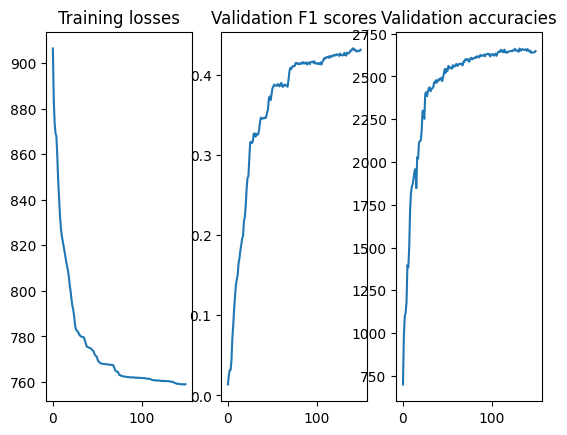

In [17]:
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [18]:
torch.save(resnet34.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet34'))

## Validating and Testing

In [3]:
model = models.resnet34(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_WEIGHTS_PATH, 'resnet34')))

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [24]:
model.eval()

ys = []
y_preds = []

for x, y in val_dl:
    x = x.to(device)
    y = y.to(device)
    y_pred = torch.max(model(x), 1)[1]
    ys.append(y)
    y_preds.append(y_pred)

y = torch.cat(ys).cpu()
y_pred = torch.cat(y_preds).cpu()

f1 = f1_score(y, y_pred, average='macro')
acc = torch.sum(y == y_pred).item()
print(f'Validated with f1={f1} and acc={acc}/{len(y)} ({acc/len(y)*100}%)')

Validated with f1=0.4318222504927245 and acc=2648/3712 (71.33620689655173%)


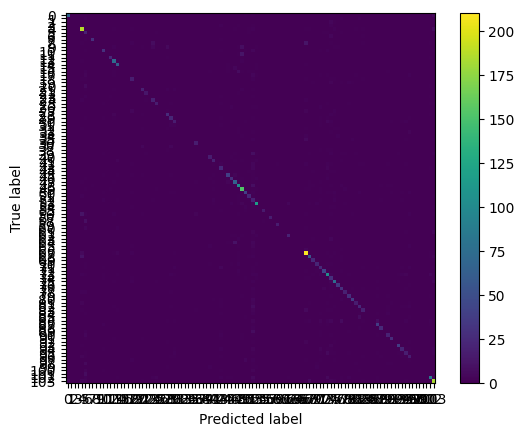

In [33]:
ConfusionMatrixDisplay.from_predictions(y, y_pred, include_values=False)
plt.show()

In [15]:
model.eval()

inds = []
y_preds = []
for x, ind in test_dl:
    x = x.to(device)
    y_pred = torch.max(model(x), 1)[1]
    inds += ind
    y_preds.append(y_pred)

y_pred = torch.cat(y_preds).cpu()

In [17]:
with open('test_preds.csv', 'w') as f:
    f.write('id,label\n')
    for ind, yp in zip(inds, y_pred):
        f.write(f'{ind},{yp}\n')